# TASK 1

### Import Libraries

In [31]:
# Import Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import tensorflow as tf       
from tensorflow import keras  
from tensorflow.keras import layers 
import warnings
warnings.filterwarnings('ignore')

# Set the aesthetic style of the plots to 'whitegrid' for better readability
sns.set(style="whitegrid")

print("Libraries imported successfully.")

Libraries imported successfully.


### Load Dataset

In [32]:
# Load the Dataset

# using try-except block to handle potential file not found errors.
try:
    # pd.read_csv: Reads the comma-separated values (CSV) file into a Pandas DataFrame.
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    
    print("Dataset loaded successfully.")

except FileNotFoundError:
    # This block executes only if Python cannot find the file specified above.
    print("Error: File not found.")
    print("Please upload 'WA_Fn-UseC_-Telco-Customer-Churn.csv' to the Colab files area.")

Dataset loaded successfully.


### Count Blank Spaces in TotalCharges

In [33]:
# Data Cleaning: Check for Invisible Missing Values

# Checking the 'TotalCharges' column for these hidden missing values.
if 'TotalCharges' in df.columns:
    blank_mask = df['TotalCharges'].astype(str).str.strip() == ''
    
    num_blank = int(blank_mask.sum())
    total_rows = len(df)
    
    # Calculate Percentage
    pct_blank = (num_blank / total_rows * 100) if total_rows else 0
    
    print(f"Missing (Blank) entries in 'TotalCharges': {num_blank} out of {total_rows} ({pct_blank:.2f}%)")
    
    # Visual Inspection
    if num_blank > 0:
        print("Sample rows with blank TotalCharges:")
        display(df.loc[blank_mask].head())

else:
    print("Column 'TotalCharges' not found. Please check column names.")

Missing (Blank) entries in 'TotalCharges': 11 out of 7043 (0.16%)
Sample rows with blank TotalCharges:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No


### Handle Missing Values in TotalCharges

In [34]:
# Correcting Data Types and Filling Missing Values

# Convert 'TotalCharges' to Numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Impute Missing Values
# Typically the empty charges relate to new customers (Tenure = 0) who haven't received a bill yet.
# Therefore, it is logical to replace NaN values with 0.
df['TotalCharges'] = df['TotalCharges'].fillna(0)

### Remove Customer ID & Churn Convertion

In [35]:
# Remove unique identifier 'customerID'
df.drop(columns=['customerID'], inplace=True)

# Convert the target 'Churn' from boolean values to binary values for modeling
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [36]:
print("Data cleaning complete.")
print(f"Dataset Shape: {df.shape}")
df.head()

Data cleaning complete.
Dataset Shape: (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


### Export Cleaned CSV

In [37]:
# Export cleaned dataset to CSV
output_csv = 'WA_Fn-UseC_-Telco-Customer-Churn_cleaned.csv'
df.to_csv(output_csv, index=False)
print(f"Cleaned dataset exported to: {output_csv} (rows: {df.shape[0]}, columns: {df.shape[1]})")

# Show first rows to confirm export
df.head()

Cleaned dataset exported to: WA_Fn-UseC_-Telco-Customer-Churn_cleaned.csv (rows: 7043, columns: 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## Exploratory Data Analysis (EDA)

### Target Distribution (Class Imbalance)

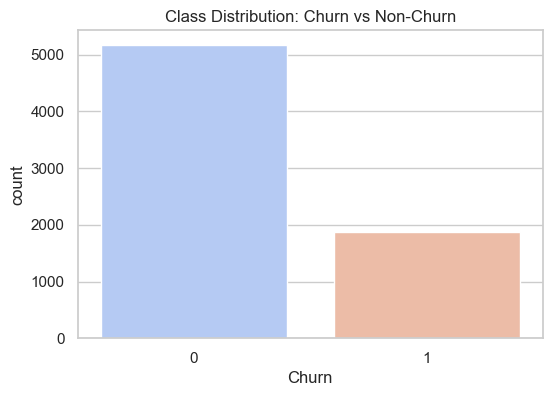

In [38]:
# Set figure size for the plot
plt.figure(figsize=(6, 4))

# Visualize the target variable 'Churn' to check for class imbalance
# sns.countplot automatically counts observations in each category
sns.countplot(x='Churn', data=df, hue='Churn', palette='coolwarm', legend=False)

# Add title and display
plt.title('Class Distribution: Churn vs Non-Churn')
plt.show()

### Numerical Features Distribution

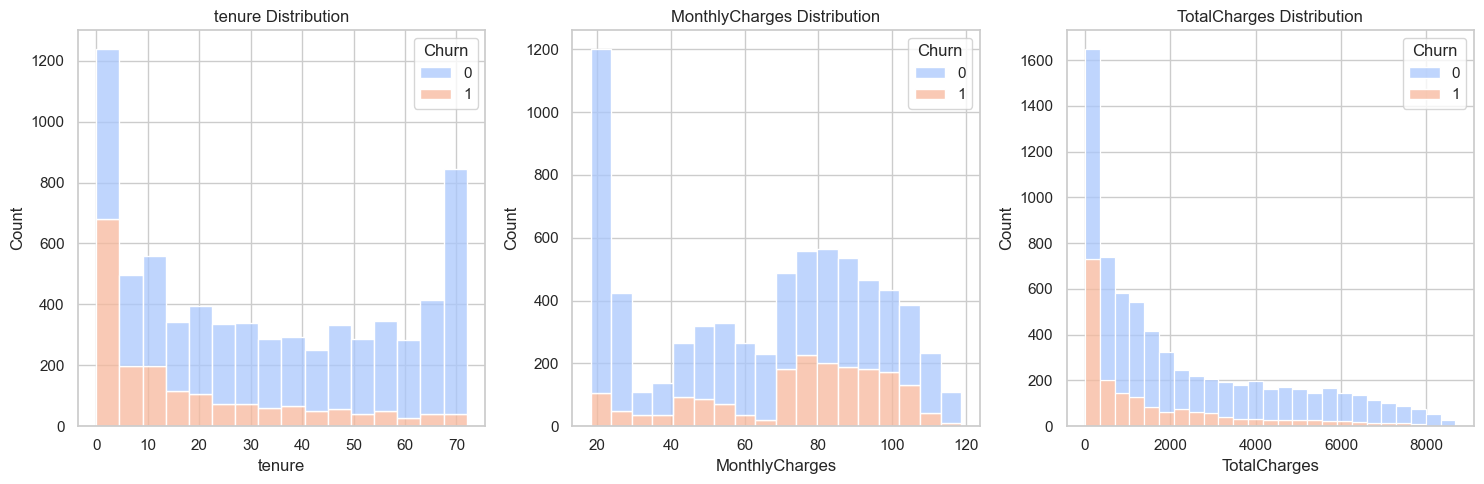

In [39]:
# Define list of numerical columns to visualize
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create a figure with 3 subplots side-by-side
plt.figure(figsize=(15, 5))

for i, col in enumerate(num_features):
    plt.subplot(1, 3, i+1)
    # Plot histogram for each feature, stacked by 'Churn' status to see relationships
    sns.histplot(df, x=col, hue='Churn', multiple="stack", palette='coolwarm')
    plt.title(f'{col} Distribution')

# Adjust layout to prevent overlap and display
plt.tight_layout()
plt.show()

### Categorical Correlations (e.g., Contract Type)

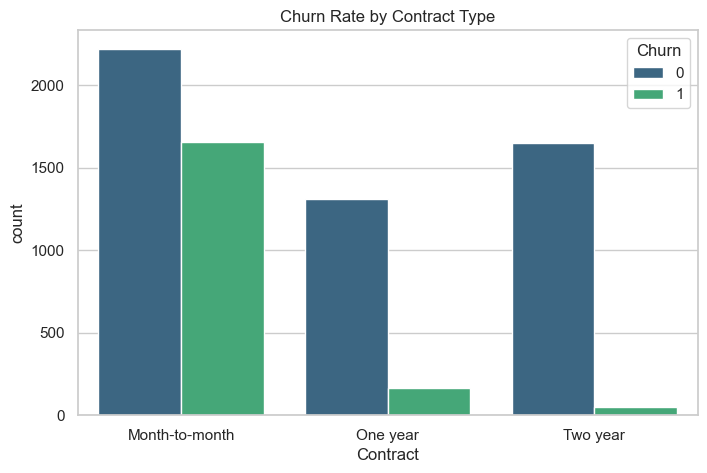

EDA Insight: 'Month-to-month' contracts have a significantly higher churn rate.


In [40]:
# Set plot dimensions
plt.figure(figsize=(8, 5))

# Plot counts of Churn vs Non-Churn for each Contract type to identify trends
# 'hue' separates the bars by Churn status (0 or 1)
sns.countplot(data=df, x='Contract', hue='Churn', palette='viridis')

# Add title and display graph
plt.title('Churn Rate by Contract Type')
plt.show()

# Print key finding from the visualization
print("EDA Insight: 'Month-to-month' contracts have a significantly higher churn rate.")

### Correlation Matrix Heatmap

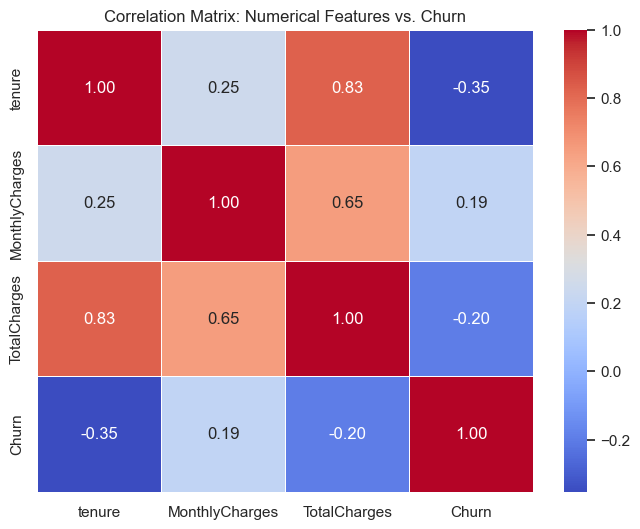

In [41]:
# Select numerical columns + Target
# Use the original 'df' but select only numbers to avoid errors
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
corr_matrix = df[num_cols].corr()

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Numerical Features vs. Churn')
plt.show()

## Data PreProcessing

### Encoding

In [42]:
# One-Hot Encoding for Categorical Variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Define Features (X) and Target (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

print("Encoding complete.")

Encoding complete.


### Check Columns 

In [43]:
print(f"Columns BEFORE Encoding: {df.shape[1]}")
print(f"Columns AFTER Encoding:  {df_encoded.shape[1]}")

# Calculate how many new columns were added
diff = df_encoded.shape[1] - df.shape[1]
print(f"New columns added: {diff}")

# show all columns
pd.set_option('display.max_columns', None)

df_encoded.head()

Columns BEFORE Encoding: 20
Columns AFTER Encoding:  31
New columns added: 11


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False


### Splitting and Scaling

In [44]:
# Split data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Splitting and Scaling complete.")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")

Splitting and Scaling complete.
Training set shape: (5634, 30)
Testing set shape: (1409, 30)


# TASK 2

## Decision Tree

### Implementation

In [45]:
dt = DecisionTreeClassifier(random_state=42)

# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Run Grid Search (5-Fold Cross Validation)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Store the best model
best_dt = grid_search.best_estimator_

print(f"Decision tree parameters (best): {grid_search.best_params_}")
print("Decision Tree Training Complete.")

Decision tree parameters (best): {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Decision Tree Training Complete.


### Model Evaluation


--- Decision Tree Classification Report ---
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1035
           1       0.67      0.39      0.49       374

    accuracy                           0.79      1409
   macro avg       0.74      0.66      0.68      1409
weighted avg       0.77      0.79      0.77      1409

ROC-AUC Score: 0.8168


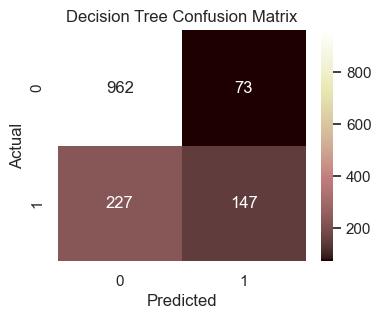

In [46]:
# Predict on Test Data
y_pred_dt = best_dt.predict(X_test_scaled)
y_prob_dt = best_dt.predict_proba(X_test_scaled)[:, 1]

# Classification Report & ROC-AUC
print("\n--- Decision Tree Classification Report ---")
print(classification_report(y_test, y_pred_dt))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_dt):.4f}")

# Confusion Matrix Visualization
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='pink')
plt.title('Decision Tree Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Neural Network

### Model Construct and Training

In [47]:
# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 32

# Build the model (Sequential API)
model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)), # Input Layer
    layers.Dropout(0.2), # Dropout to prevent overfitting
    layers.Dense(16, activation='relu'), # Hidden Layer
    layers.Dense(1, activation='sigmoid') # Output Layer (Sigmoid for binary classification)
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks (Early Stopping & Model Checkpoint)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=0),
    ModelCheckpoint('best_nn_model.keras', monitor='val_loss', save_best_only=True, verbose=0)
]

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1,
    callbacks=callbacks
)

print("Neural Network Training Complete.")

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6510 - loss: 0.6144 - val_accuracy: 0.7835 - val_loss: 0.4760 - learning_rate: 0.0010
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7912 - loss: 0.4549 - val_accuracy: 0.7817 - val_loss: 0.4527 - learning_rate: 0.0010
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7970 - loss: 0.4363 - val_accuracy: 0.7853 - val_loss: 0.4462 - learning_rate: 0.0010
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7976 - loss: 0.4298 - val_accuracy: 0.7870 - val_loss: 0.4440 - learning_rate: 0.0010
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8036 - loss: 0.4197 - val_accuracy: 0.7888 - val_loss: 0.4417 - learning_rate: 0.0010
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8016 - loss: 0.4215 - val_accuracy: 0.7924 - val_loss: 0.4390 - learning_rate: 0.0010
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8052 - loss: 0.4185 - 

### Training & Validation Curves (Loss & Accuracy)

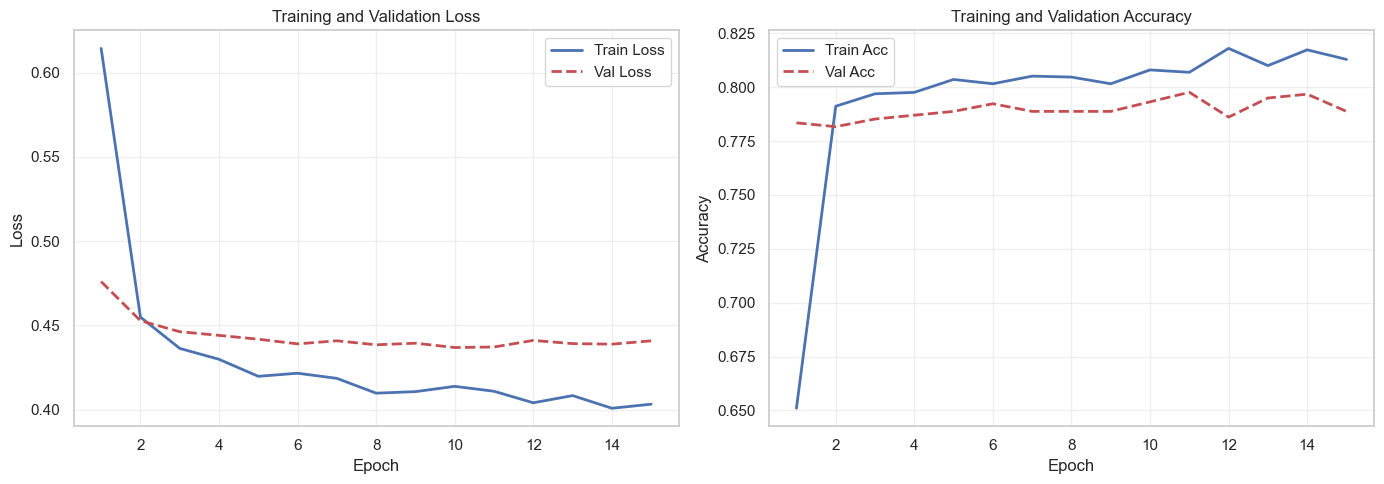

Training curves saved to: nn_training_curves.png


In [48]:
# Plot and save clear training & validation loss and accuracy curves

if 'history' not in globals():
    print("No training history found. Run the Neural Network training cell first to generate `history`.")
else:
    hist = history.history
    epochs = range(1, len(hist.get('loss', [])) + 1)
    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist.get('loss', []), 'b-', linewidth=2, label='Train Loss')
    plt.plot(epochs, hist.get('val_loss', []), 'r--', linewidth=2, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(alpha=0.3)
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    acc_key = 'accuracy' if 'accuracy' in hist else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in hist else 'val_acc'
    plt.plot(epochs, hist.get(acc_key, []), 'b-', linewidth=2, label='Train Acc')
    plt.plot(epochs, hist.get(val_acc_key, []), 'r--', linewidth=2, label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    out_file = 'nn_training_curves.png'
    
    plt.savefig(out_file, dpi=150)
    plt.show()

    print(f"Training curves saved to: {out_file}")

In [49]:
# Make predictions on test data
y_prob_nn = model.predict(X_test_scaled).flatten()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

print("Neural Network Predictions Complete.")
print(f"Predictions shape: {y_pred_nn.shape}")
print(f"Sample predictions (first 10): {y_pred_nn[:10]}")
print(f"Sample probabilities (first 10): {y_prob_nn[:10]}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Neural Network Predictions Complete.
Predictions shape: (1409,)
Sample predictions (first 10): [0 1 0 0 0 1 0 0 0 0]
Sample probabilities (first 10): [0.06007675 0.722994   0.0488507  0.34726506 0.01177299 0.6483188
 0.43520385 0.13368785 0.00577393 0.46453816]


### Model Evaluation

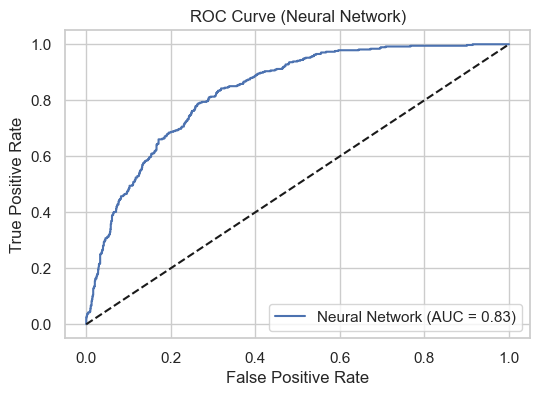

In [50]:
# ROC Curve Visualization
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)
plt.figure(figsize=(6, 4))
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {roc_auc_score(y_test, y_prob_nn):.2f})")
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Neural Network)')
plt.legend()
plt.show()

### Final Evaluation & Comparison

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Neural Network Classification Report ---
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.62      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC-AUC Score: 0.8335


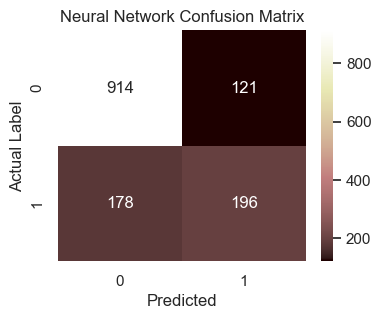

In [51]:
# Generate Predictions
# Neural Networks output probabilities (0.0 to 1.0).
# We threshold them at 0.5 to get binary class predictions (0 or 1).
y_prob_nn = model.predict(X_test_scaled)    
y_pred_nn = (y_prob_nn > 0.5).astype("int32")

# Print Classification Report
print("\n--- Neural Network Classification Report ---")
print(classification_report(y_test, y_pred_nn))

# Calculate ROC-AUC Score
roc_auc_nn = roc_auc_score(y_test, y_prob_nn)
print(f"ROC-AUC Score: {roc_auc_nn:.4f}")

# Visualize Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='pink') # Using 'pink' to distinguish from Decision Tree
plt.title('Neural Network Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted')
plt.show()

### Evaluation Comparison

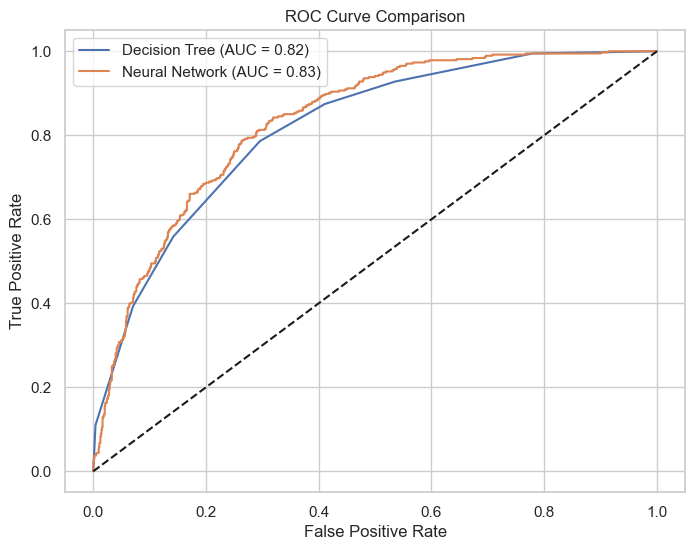

In [52]:
# ROC Curve Comparison Plot
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_score(y_test, y_prob_dt):.2f})")
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {roc_auc_score(y_test, y_prob_nn):.2f})")
plt.plot([0, 1], [0, 1], 'k--') # Diagonal random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()